In [1]:
import sys
import os
import pandas as pd

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, \
    scale, \
    metrics_r, get_device, plot_history, load_best_params, print_best_params_nn, fmt_time, save_best_params, \
    save_tuning_history, plot_tuning_heatmap, print_tuning_top_results, load_tuning_history,plot_param_loss_corr

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train, tune

## Set Working Device

In [5]:
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


## Read Features and Targets

In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


## Train-Validation Split

In [9]:
X, y = train_val_split(X, y)

## Scale Regression Targets

In [10]:
y, y_scaler = scale(y)

In [11]:
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}

## Dimensions

In [12]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


## Torch Datasets and Dataloaders

In [13]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Load Best Params

In [14]:
path_params = "best_params.json"
path_history = "tuning_history.csv"

best_params = load_best_params(path_params)
print(f"Best Params Available for {len(best_params.keys())} Models")

tuning_histories = load_tuning_history(path_history)

Best Params Available for 5 Models


## Tune Model



In [15]:
criterion = nn.MSELoss()
metrics = metrics_r

param_grid = {
    # Architecture Params
    # "hidden_size": [128, 256, 512, 1024],
    "hidden_size": [128, 256, 512],
    "activation": ["relu", "gelu"],
    # "dropout": [0, 0.1, 0.3, 0.5],
    "dropout": [0.1, 0.2],
    # "blocks": [1, 2, 3, 5, 10],
    "blocks": [1, 2, 3],
    "hidden_size_pattern": ["decreasing", "constant"],

    # Training Params
    # "lr": [1e-2, 1e-3, 1e-4, 1e-5],
    "lr": [1e-2, 5e-3, 1e-3],
    # "weight_decay": [1e-5, 1e-6, 1e-7],
    "weight_decay": [1e-6],
}

In [16]:
flag_new_model = False
log_metrics = ["mae"]

for ft in feature_types:
    if ft not in best_params.keys():
        flag_new_model = True
        print(f"\n🔄 Tuning MLP with '{ft.upper()}' Features")
        tuning_result, tuning_history = tune(
            param_grid,
            [X_dim[ft]],
            y_dim,
            loaders["train"][ft],
            loaders["val"][ft],
            criterion,
            metrics,
            device,
            y_scaler,
            log_metrics=log_metrics,
            log_per_M=100,
            chronology_target="years"
        )

        best_params[ft] = tuning_result
        tuning_histories[ft] = tuning_history
    else:
        print(f"\n✅ MLP with '{ft.upper()}' Features Already Tuned.", end=" ")
        print_best_params_nn(best_params[ft], param_grid, y_dim, log_metrics)

for ft_txt, ft_img in feature_type_combos:
    if True: break
    ft = ft_txt + " + " + ft_img
    tuning_result, tuning_history = tune(
        param_grid,
        [X_dim[ft_txt], X_dim[ft_img]],
        y_dim,
        loaders["train"][ft],
        loaders["val"][ft],
        criterion,
        metrics,
        device,
        y_scaler,
        log_metrics=log_metrics,
        chronology_target="years"
    )

    best_params[ft] = tuning_result
    tuning_histories[ft] = tuning_history



✅ MLP with 'TFIDF' Features Already Tuned. Execution Time: 1m 47s
+-----------+-------------+------------+---------+--------+---------------------+-------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |    lr |  val_loss |     mae_0 |     mae_1 |
+-----------+-------------+------------+---------+--------+---------------------+-------+-----------+-----------+-----------+
|      BEST |         512 |       relu |     0.2 |      3 |            constant | 0.005 |    0.6489 |   34.9025 |   10.2801 |
+-----------+-------------+------------+---------+--------+---------------------+-------+-----------+-----------+-----------+

✅ MLP with 'BERT' Features Already Tuned. Execution Time: 3m 34s
+-----------+-------------+------------+---------+--------+---------------------+-------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |    lr |  val_loss |     mae_0

## Save Best Params And Tunning History

In [17]:
save_best_params("best_params.json", best_params, flag_new_model)
save_tuning_history("tuning_history.csv", tuning_histories, flag_new_model)

✅ No new tuning needed — using existing parameters.


## Evaluate Tuning Results



📈 Tuning results for BERT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
220,relu,1,0.1,128,constant,0.005,0.000001,0.620367,0.790942,44.547527,10.978114,56.692760,13.326800,0.356666,0.117797,37.948166,9.974106
355,gelu,1,0.2,512,decreasing,0.005,0.000001,0.623165,0.794473,43.563408,11.084286,55.990013,13.493342,0.372517,0.095610,34.755966,10.685182
221,relu,1,0.1,128,constant,0.001,0.000001,0.616278,0.796485,43.842861,11.037619,56.408375,13.476456,0.363105,0.097872,35.752869,10.646272
311,relu,3,0.2,128,constant,0.001,0.000001,0.636317,0.797706,43.967136,10.966906,57.967651,13.252788,0.327407,0.127569,35.350342,9.853128
222,relu,1,0.1,256,decreasing,0.010,0.000001,0.669792,0.800513,45.105152,10.888268,57.455051,13.340101,0.339250,0.116035,38.626633,9.425301



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
296,relu,3,0.1,256,decreasing,0.001,0.000001,0.561965,0.803113,42.771935,11.067234,56.280716,13.563869,0.365984,0.086131,35.727249,9.903189
281,relu,2,0.2,256,constant,0.001,0.000001,0.544380,0.828770,43.098797,11.269166,57.755749,13.684854,0.332315,0.069755,32.166504,10.793056
224,relu,1,0.1,256,decreasing,0.001,0.000001,0.600161,0.801143,43.298702,11.159116,55.411453,13.666953,0.385418,0.072188,36.506714,10.619606
364,gelu,2,0.1,128,constant,0.005,0.000001,0.565045,0.812721,43.516563,11.106674,56.186047,13.780788,0.368115,0.056667,36.227982,9.900469
263,relu,2,0.1,256,constant,0.001,0.000001,0.558873,0.819018,43.519764,11.401313,55.796120,13.863769,0.376855,0.045273,34.930878,10.893938



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
289,relu,3,0.1,128,decreasing,0.005,0.000001,0.730487,0.837232,46.871723,10.414988,59.667931,13.334550,0.287372,0.116771,39.356888,7.496231
373,gelu,2,0.1,512,decreasing,0.005,0.000001,0.702473,0.834040,48.442711,10.665178,60.942841,13.194301,0.256593,0.135252,40.551117,10.245792
422,gelu,3,0.2,256,decreasing,0.001,0.000001,0.625062,0.831558,46.828609,10.735186,59.804829,13.390000,0.284098,0.109410,37.960114,9.176968
325,gelu,1,0.1,128,decreasing,0.005,0.000001,0.642861,0.804781,45.833622,10.815250,57.987450,13.289129,0.326947,0.122777,39.666809,9.959644
391,gelu,2,0.2,512,decreasing,0.005,0.000001,0.665434,0.815249,45.441555,10.816891,58.701519,13.344225,0.310269,0.115488,37.873428,9.594576


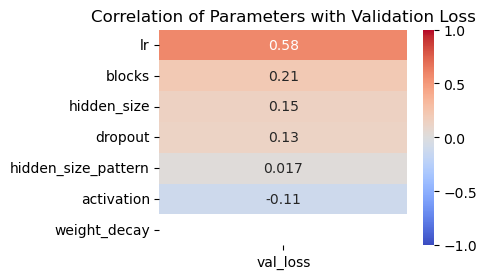

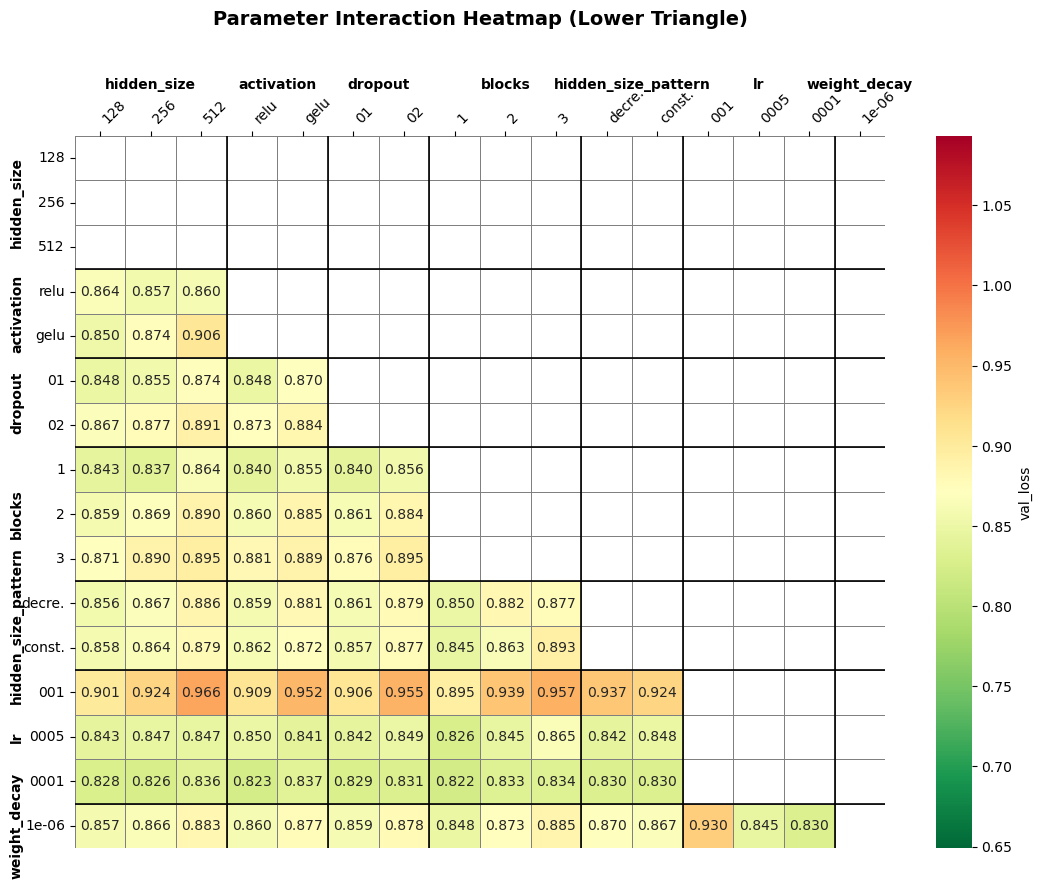



📈 Tuning results for CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
470,relu,2,0.1,128,decreasing,0.001,0.000001,0.852011,0.988120,54.071030,12.182803,66.117119,14.317409,0.124998,-0.018229,54.750031,9.351166
443,relu,1,0.1,256,constant,0.001,0.000001,0.797600,0.995366,54.150471,12.086213,66.565376,14.339419,0.113094,-0.021363,50.794479,9.239672
545,gelu,1,0.1,128,constant,0.001,0.000001,0.850208,1.004994,54.542305,12.225127,66.645813,14.402792,0.110949,-0.030410,49.175873,10.076430
509,relu,3,0.1,128,constant,0.001,0.000001,0.850043,1.008281,54.733559,12.387400,66.608765,14.465621,0.111937,-0.039420,54.008972,11.302898
563,gelu,1,0.2,128,constant,0.001,0.000001,0.845168,1.009212,55.384548,12.187560,67.021713,14.369818,0.100892,-0.025698,48.599228,9.926319



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
470,relu,2,0.1,128,decreasing,0.001,0.000001,0.852011,0.988120,54.071030,12.182803,66.117119,14.317409,0.124998,-0.018229,54.750031,9.351166
443,relu,1,0.1,256,constant,0.001,0.000001,0.797600,0.995366,54.150471,12.086213,66.565376,14.339419,0.113094,-0.021363,50.794479,9.239672
545,gelu,1,0.1,128,constant,0.001,0.000001,0.850208,1.004994,54.542305,12.225127,66.645813,14.402792,0.110949,-0.030410,49.175873,10.076430
581,gelu,2,0.1,128,constant,0.001,0.000001,0.834361,1.014390,54.719433,12.356891,67.113945,14.427089,0.098415,-0.033890,50.789322,10.540024
509,relu,3,0.1,128,constant,0.001,0.000001,0.850043,1.008281,54.733559,12.387400,66.608765,14.465621,0.111937,-0.039420,54.008972,11.302898



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
555,gelu,1,0.1,512,constant,0.010,0.000001,1.026291,1.073110,59.558002,11.608808,71.483414,14.240594,-0.022802,-0.007333,55.109070,8.364415
591,gelu,2,0.1,512,constant,0.010,0.000001,3.441896,1.065145,60.141087,11.647271,71.257011,14.237848,-0.016334,-0.006945,55.625565,8.146327
552,gelu,1,0.1,512,decreasing,0.010,0.000001,1.203818,1.060019,59.508152,11.738836,70.983414,14.199763,-0.008544,-0.001565,51.525055,8.338626
457,relu,1,0.2,256,decreasing,0.005,0.000001,16.815086,1.075457,59.275021,11.890937,71.041710,14.357574,-0.010201,-0.023950,51.678162,8.897446
546,gelu,1,0.1,256,decreasing,0.010,0.000001,1.117950,1.075585,59.326511,11.962171,71.628494,14.252704,-0.026958,-0.009047,56.608948,8.257519


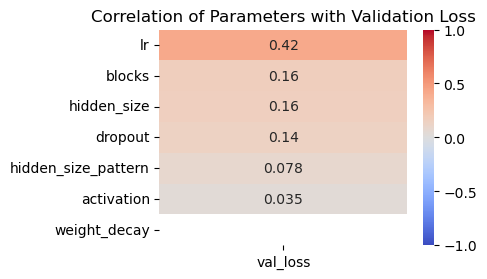

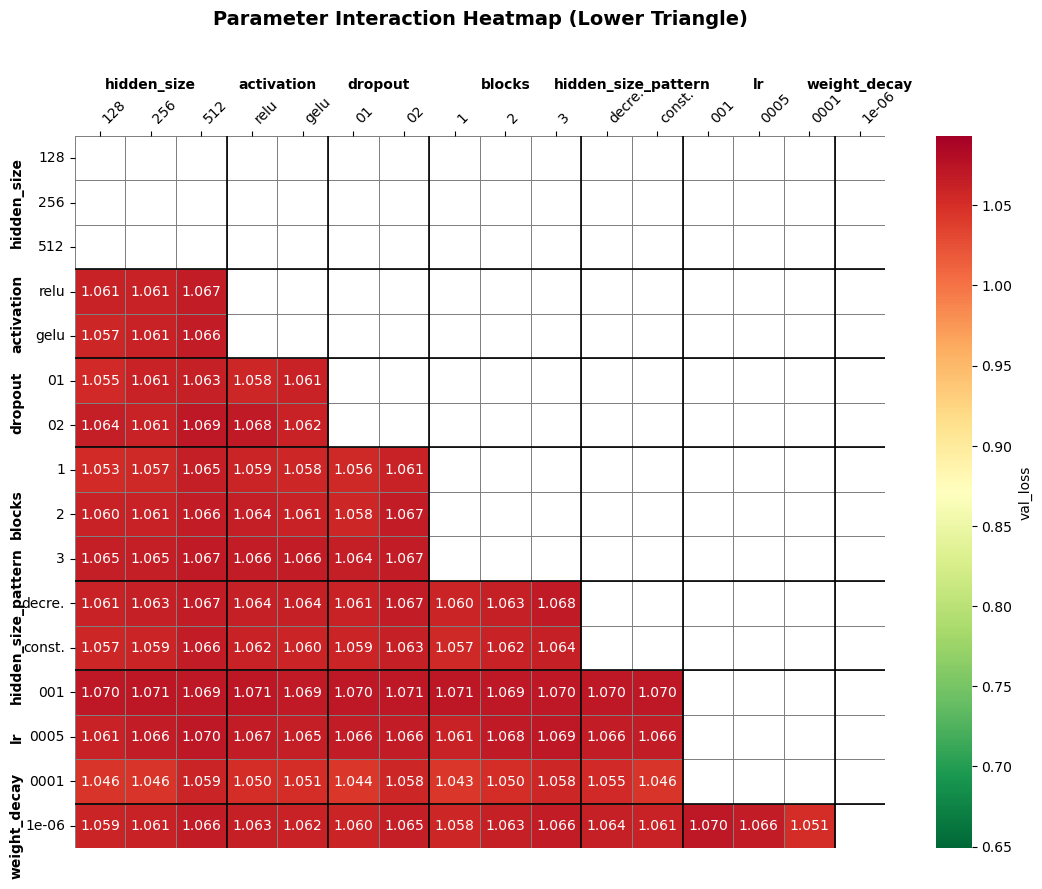



📈 Tuning results for RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
677,relu,1,0.2,256,constant,0.001,0.000001,0.778844,0.913465,50.602524,11.461333,62.275703,14.005039,0.223720,0.025716,43.500000,8.661989
715,relu,2,0.2,512,decreasing,0.005,0.000001,0.793420,0.915173,49.165310,12.192029,61.439419,14.239267,0.244429,-0.007145,41.523117,10.350885
844,gelu,3,0.1,512,constant,0.005,0.000001,0.757892,0.920560,48.305771,11.856140,60.571117,14.347256,0.265635,-0.022479,40.610168,8.796831
671,relu,1,0.2,128,constant,0.001,0.000001,0.754924,0.921608,49.712074,11.964895,61.707951,14.260586,0.237810,-0.010163,44.514893,9.289576
653,relu,1,0.1,128,constant,0.001,0.000001,0.849546,0.921976,50.730865,11.948063,62.488342,14.111607,0.218410,0.010833,43.554626,10.035387



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
692,relu,2,0.1,256,decreasing,0.001,0.000001,0.714179,0.923225,47.800735,12.016518,61.990799,14.262348,0.230807,-0.010413,36.910553,9.577719
799,gelu,2,0.1,256,decreasing,0.005,0.000001,0.679758,0.948168,48.089005,12.019419,63.312035,14.379927,0.197669,-0.027141,41.078018,8.915365
844,gelu,3,0.1,512,constant,0.005,0.000001,0.757892,0.920560,48.305771,11.856140,60.571117,14.347256,0.265635,-0.022479,40.610168,8.796831
737,relu,3,0.1,512,constant,0.001,0.000001,0.690603,0.955168,48.361584,12.284872,62.219971,14.603898,0.225109,-0.059386,38.431335,10.043771
832,gelu,3,0.1,128,constant,0.005,0.000001,0.727419,0.935736,48.369038,12.062087,62.508820,14.296034,0.217898,-0.015191,36.313858,9.688292



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
777,gelu,1,0.2,128,constant,0.010,0.000001,0.814514,0.925142,49.552422,11.326542,63.568573,13.991461,0.191154,0.027605,41.000000,8.103580
770,gelu,1,0.1,512,decreasing,0.001,0.000001,0.821383,0.934514,50.985546,11.357183,63.387733,14.122577,0.195749,0.009294,43.500000,8.741194
677,relu,1,0.2,256,constant,0.001,0.000001,0.778844,0.913465,50.602524,11.461333,62.275703,14.005039,0.223720,0.025716,43.500000,8.661989
845,gelu,3,0.1,512,constant,0.001,0.000001,0.819944,0.926106,51.006268,11.517946,62.648014,14.096656,0.214411,0.012928,44.273529,8.461861
801,gelu,2,0.1,256,constant,0.010,0.000001,0.825047,0.926543,51.295170,11.543291,62.471428,14.158646,0.218833,0.004227,48.800476,8.299601


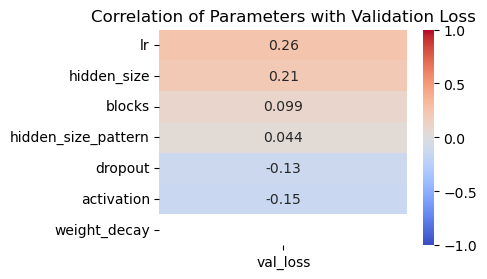

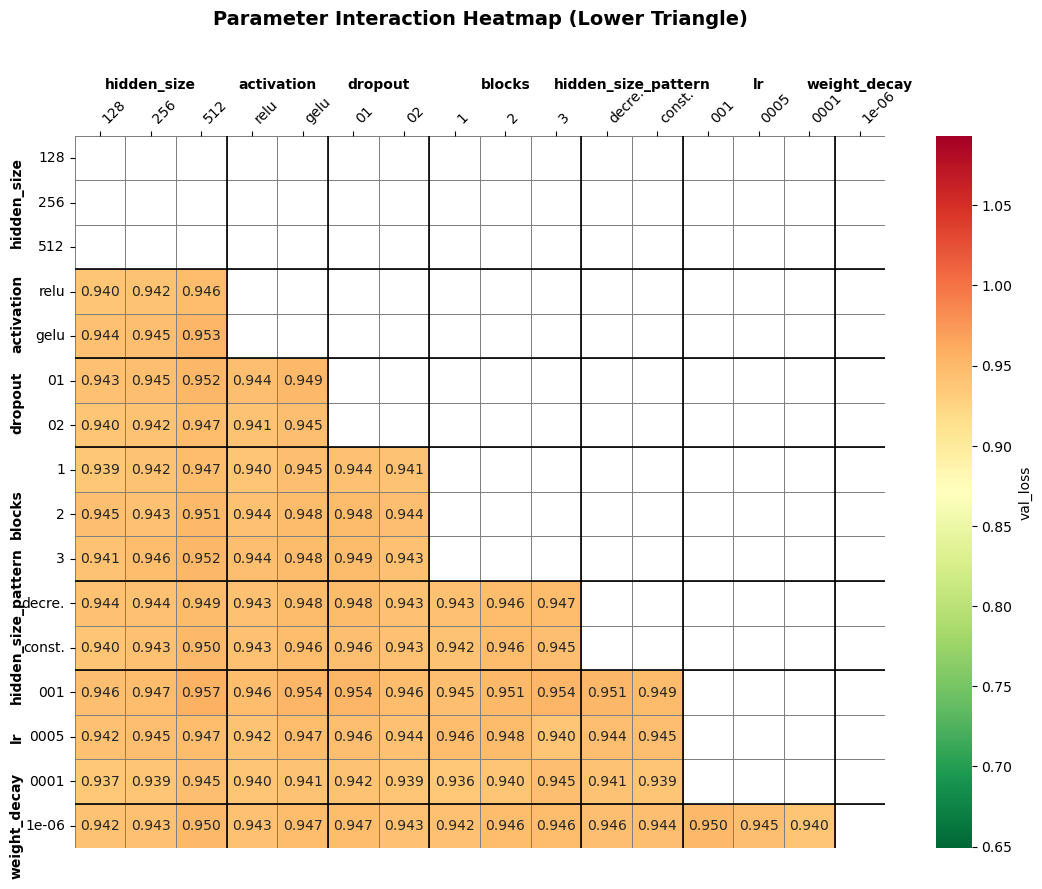



📈 Tuning results for TFIDF features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
106,relu,3,0.2,512,constant,0.005,0.000001,0.561493,0.648942,34.902485,10.280133,46.946445,12.541409,0.558850,0.218715,28.802826,10.706310
16,relu,1,0.1,512,constant,0.005,0.000001,0.588472,0.657112,37.374435,10.056602,49.390213,12.226337,0.511727,0.257478,26.710098,8.900047
39,relu,2,0.1,128,constant,0.010,0.000001,0.547264,0.659791,35.894028,10.447392,47.617046,12.600822,0.546157,0.211295,24.838974,9.954670
0,relu,1,0.1,128,decreasing,0.010,0.000001,0.451772,0.660650,35.672169,10.439029,47.309860,12.606077,0.551993,0.210637,25.991852,10.270104
30,relu,1,0.2,512,decreasing,0.010,0.000001,0.390096,0.662780,37.232479,10.212897,49.752411,12.373119,0.504539,0.239542,26.925125,9.634447



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
48,relu,2,0.1,512,decreasing,0.010,0.000001,0.208005,0.686398,33.902973,10.510513,46.776276,13.133125,0.562042,0.143252,22.663651,8.705866
67,relu,2,0.2,512,decreasing,0.005,0.000001,0.127449,0.685565,33.965527,10.118096,47.904800,12.902678,0.540655,0.173055,21.636597,8.069818
73,relu,3,0.1,128,decreasing,0.005,0.000001,0.365231,0.686668,34.117733,10.232429,48.053936,12.865472,0.537790,0.177817,21.470352,9.395082
33,relu,1,0.2,512,constant,0.010,0.000001,0.134934,0.683080,34.227280,10.380904,46.938038,13.029093,0.559008,0.156772,21.038727,8.831615
24,relu,1,0.2,256,decreasing,0.010,0.000001,0.186430,0.688444,34.369602,10.340623,47.385124,13.024611,0.550567,0.157352,25.906281,8.185258



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
36,relu,2,0.1,128,decreasing,0.010,0.000001,0.463778,0.680841,38.928238,10.003073,50.756714,12.476998,0.484335,0.226719,29.539062,8.800829
89,relu,3,0.1,512,constant,0.001,0.000001,0.359801,0.702703,37.268082,10.004671,51.273548,12.678855,0.473779,0.201496,26.071960,8.507788
28,relu,1,0.2,256,constant,0.005,0.000001,0.457779,0.689205,39.313107,10.031540,51.947132,12.329092,0.459863,0.244944,28.905457,9.221167
16,relu,1,0.1,512,constant,0.005,0.000001,0.588472,0.657112,37.374435,10.056602,49.390213,12.226337,0.511727,0.257478,26.710098,8.900047
31,relu,1,0.2,512,decreasing,0.005,0.000001,0.601365,0.696533,40.929382,10.084655,52.124565,12.444062,0.456166,0.230797,31.677826,9.568054


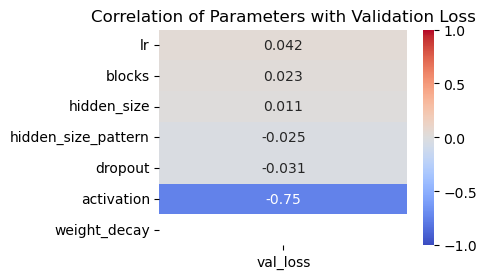

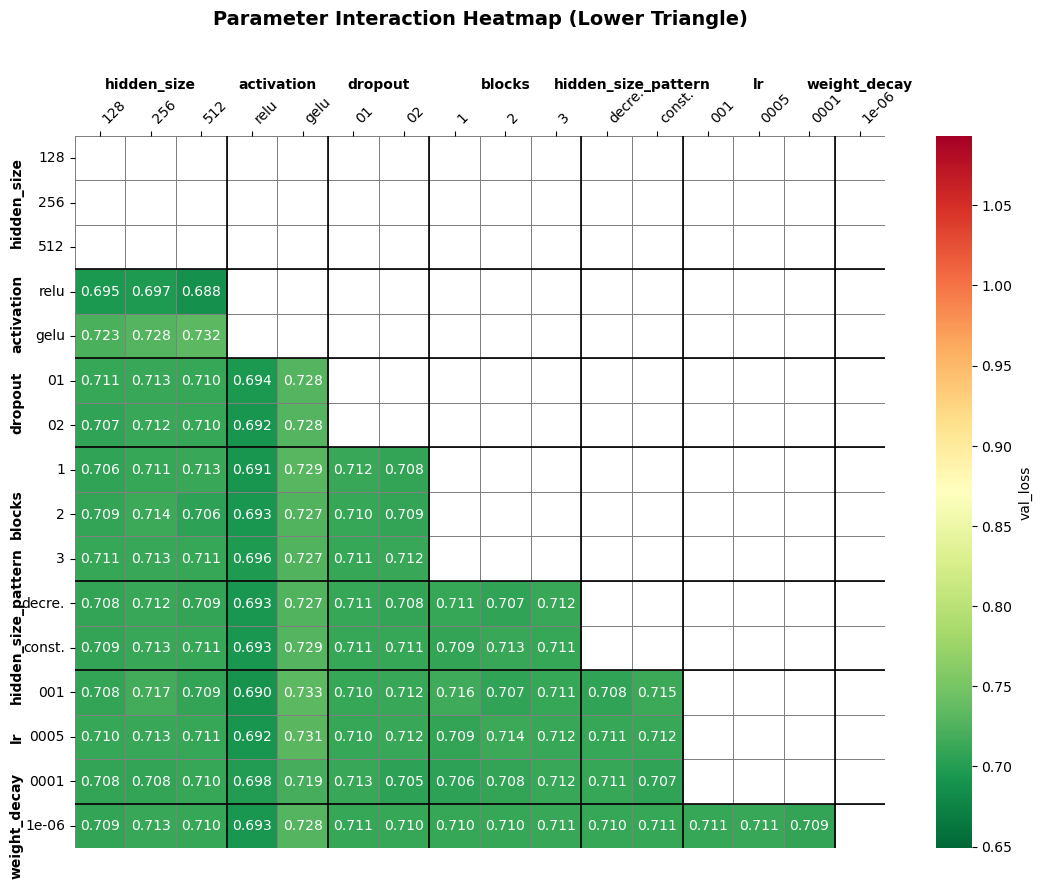



📈 Tuning results for VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
936,relu,3,0.1,128,decreasing,0.010,0.000001,0.746286,0.898287,47.929581,11.488503,61.379486,13.898449,0.245902,0.040490,36.853333,8.135085
1012,gelu,2,0.1,128,constant,0.005,0.000001,0.701213,0.899124,47.521824,11.580312,60.834408,14.039480,0.259237,0.020918,38.927887,8.384979
1039,gelu,2,0.2,512,decreasing,0.005,0.000001,0.822209,0.899490,49.303352,11.453305,61.394169,13.924021,0.245542,0.036956,43.581284,8.227594
952,relu,3,0.1,512,constant,0.005,0.000001,0.782450,0.902441,48.716377,11.794536,61.501045,14.022882,0.242913,0.023232,41.190109,9.700288
961,relu,3,0.2,256,decreasing,0.005,0.000001,0.732032,0.902507,46.762684,12.034886,60.122204,14.203793,0.276480,-0.002133,41.727188,9.873400



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1048,gelu,3,0.1,128,constant,0.005,0.000001,0.688798,0.924677,46.265831,12.061228,60.359222,14.410357,0.270764,-0.031493,37.713959,9.472713
959,relu,3,0.2,128,constant,0.001,0.000001,0.731334,0.925724,46.377880,12.189474,60.583961,14.412676,0.265323,-0.031825,33.641663,9.636168
1005,gelu,1,0.2,512,constant,0.010,0.000001,0.666832,0.925353,46.384060,12.008783,61.100060,14.375076,0.252753,-0.026448,36.987579,9.464180
872,relu,1,0.1,256,decreasing,0.001,0.000001,0.675903,0.927061,46.387390,12.077435,60.745850,14.408598,0.261392,-0.031241,35.801834,8.909451
994,gelu,1,0.2,128,constant,0.005,0.000001,0.677582,0.922389,46.395416,11.962871,60.612862,14.391122,0.264622,-0.028741,36.752319,8.859535



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
908,relu,2,0.1,256,decreasing,0.001,0.000001,0.768475,0.926945,49.001778,11.328200,62.460270,14.125881,0.219112,0.008831,41.979431,8.344627
998,gelu,1,0.2,256,decreasing,0.001,0.000001,0.738663,0.920221,49.612652,11.366400,63.031971,13.913647,0.204752,0.038390,39.842239,8.357208
917,relu,2,0.1,512,constant,0.001,0.000001,0.752898,0.920518,48.868179,11.405524,62.158920,14.099040,0.226629,0.012594,41.121368,8.840464
1043,gelu,2,0.2,512,constant,0.001,0.000001,0.759031,0.917054,50.227573,11.410151,62.759533,13.934606,0.211611,0.035491,41.617310,8.621307
1009,gelu,2,0.1,128,decreasing,0.005,0.000001,0.767802,0.946672,50.962463,11.415157,63.496819,14.150179,0.192979,0.005418,44.593781,8.711676


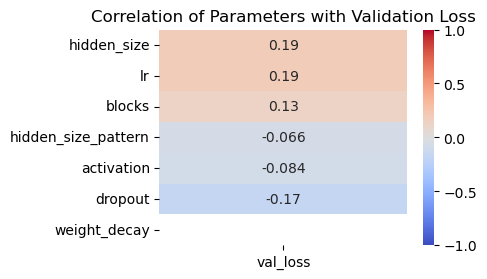

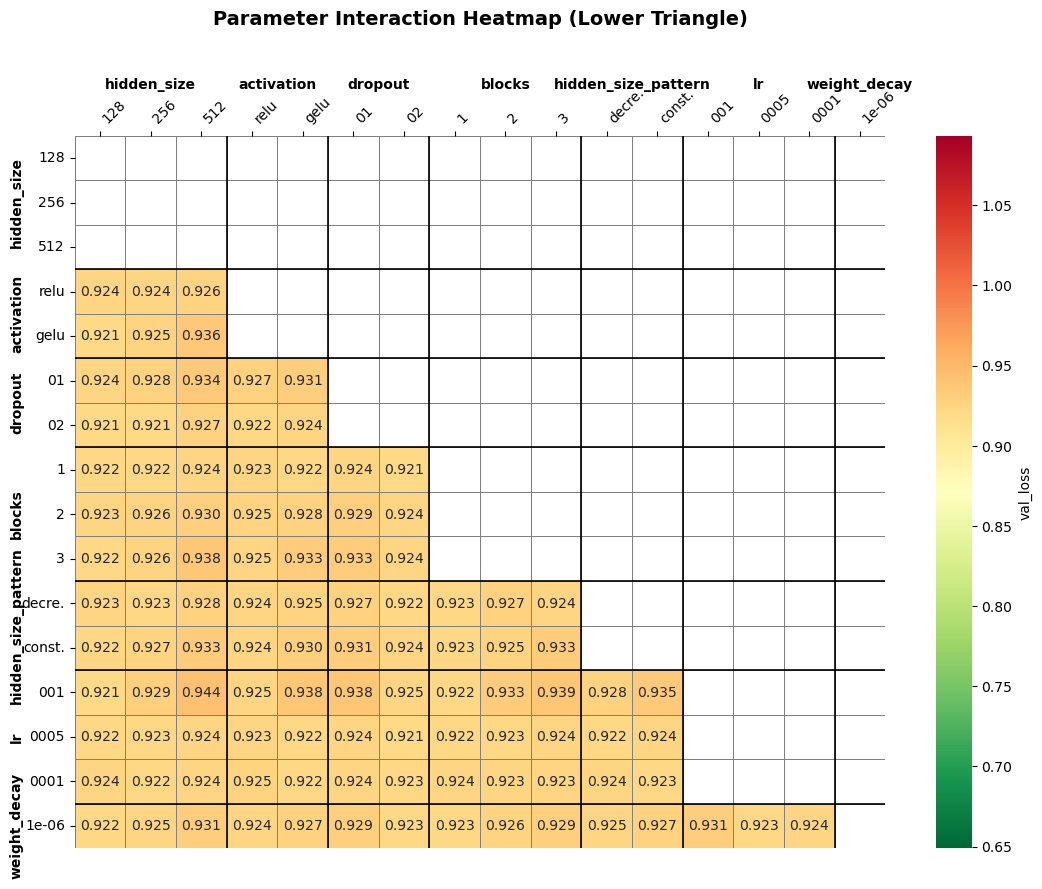

In [19]:
all_val_losses = pd.concat([tuning_history["val_loss"] for tuning_history in tuning_histories.values()])
val_loss_range = (all_val_losses.min(), all_val_losses.max())

for ft, tuning_history in tuning_histories.items():
    print(f"\n\n📈 Tuning results for {ft.upper()} features model:")
    print_tuning_top_results(tuning_history, topN=5, top_by=["val_loss", "mae"])

    plot_param_loss_corr(tuning_history, param_grid)
    plot_tuning_heatmap(tuning_history, param_grid, loss_range=val_loss_range)